In [ ]:
# ============================================================================
# COLAB SETUP - Run this cell first!
# ============================================================================
import sys
from pathlib import Path

# Detect if running in Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Running in Google Colab")

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Set up paths
    DRIVE_ROOT = Path('/content/drive/MyDrive/chaos')
    DRIVE_ROOT.mkdir(parents=True, exist_ok=True)

    print(f"Drive mounted. Project root: {DRIVE_ROOT}")
else:
    print("Running locally")
    DRIVE_ROOT = None


Running in Google Colab
Mounted at /content/drive
Drive mounted. Project root: /content/drive/MyDrive/chaos


In [ ]:
# ============================================================================
# COLAB: Install dependencies and upload src.zip
# ============================================================================
if IN_COLAB:
    print("Installing dependencies...")
    !pip install -q torch>=2.0.0 h5py>=3.8.0 sgfmill>=1.1.0
    !pip install -q matplotlib>=3.7.0 tqdm>=4.65.0
    !pip install -q scikit-learn>=1.2.0 scipy>=1.10.0
    print("Dependencies installed!")

    # Upload src.zip (lightweight, may change between sessions)
    import os
    import zipfile
    from google.colab import files

    !unzip -n -q src.zip -d /content/


Installing dependencies...
Dependencies installed!


# 01 - Data Validation and Activation Extraction

This notebook:
1. **Validates** pre-encoded positions from `positions.hdf5`
2. **Sanity checks** encoding format, value ranges, data integrity
3. **Statistics** on game/move distributions
4. **Extracts activations** from Leela Zero blocks 5, 20, 35
5. **Computes normalization** statistics for downstream training

**Prerequisites**: Run `scripts/sample_games.py` to create `outputs/data/positions.hdf5`

**Data Format**: 18-plane Leela Zero encoding
- Planes 0-7: Current player stones (t=0 to t=-7)
- Planes 8-15: Opponent stones (t=0 to t=-7)
- Plane 16: All 1s if black to move, else 0s
- Plane 17: All 1s if white to move, else 0s

## Setup

In [ ]:
import sys
import os
sys.path.insert(0, '.')

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Configuration
CONFIG = {
    'output_dir': 'outputs',
    'board_size': 19,
    'block_indices': [5, 20, 35],  # Early, middle, late layers
    'batch_size': 256,  # Optimized for CUDA (T4/A100)
    'max_positions': None,  # Set to limit for testing
    'spatial_mode': 'pool',
    'pool_mode': 'mean',
}

# Device selection
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
        return device
    if torch.backends.mps.is_available():
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        print("Using MPS (Apple Silicon)")
        return torch.device('mps')
    print("Using CPU")
    return torch.device('cpu')

device = get_device()

Using CUDA: Tesla T4


In [ ]:
# ============================================================================
# COLAB: Configure paths for Drive storage
# ============================================================================
if IN_COLAB:
    # Override paths to use Google Drive
    CONFIG['output_dir'] = str(DRIVE_ROOT)

    # Ensure output directories exist
    (DRIVE_ROOT / 'data').mkdir(parents=True, exist_ok=True)
    (DRIVE_ROOT / 'data' / 'activations').mkdir(parents=True, exist_ok=True)

    print(f"Output directory: {CONFIG['output_dir']}")
    print(f"  - positions.hdf5 will be read from: {DRIVE_ROOT / 'data' / 'positions.hdf5'}")
    print(f"  - activations will be saved to: {DRIVE_ROOT / 'data' / 'activations'}")


Output directory: /content/drive/MyDrive/chaos
  - positions.hdf5 will be read from: /content/drive/MyDrive/chaos/data/positions.hdf5
  - activations will be saved to: /content/drive/MyDrive/chaos/data/activations


## 1. Load and Validate Data

In [ ]:
from src.data import load_positions_hdf5
import h5py

positions_path = Path(CONFIG['output_dir']) / 'data' / 'positions.hdf5'

# First, inspect raw HDF5 structure
print("=" * 60)
print("HDF5 FILE STRUCTURE")
print("=" * 60)
with h5py.File(positions_path, 'r') as f:
    print(f"\nDatasets:")
    for key in f.keys():
        ds = f[key]
        print(f"  {key}: shape={ds.shape}, dtype={ds.dtype}")

    print(f"\nAttributes (config):")
    for k, v in f.attrs.items():
        print(f"  {k}: {v}")

HDF5 FILE STRUCTURE

Datasets:
  game_ids: shape=(495995,), dtype=int32
  move_numbers: shape=(495995,), dtype=int16
  positions: shape=(495995, 18, 19, 19), dtype=float32

Attributes (config):
  board_size: 19
  max_move: 150
  min_move: 10
  n_games: 4999
  n_positions: 495995
  positions_per_game: 100
  seed: 42
  source: all_21M.sgf.xz


In [ ]:
# Load positions
positions_array, metadata = load_positions_hdf5(
    str(positions_path),
    max_positions=CONFIG['max_positions']
)

print("\n" + "=" * 60)
print("LOADED DATA SUMMARY")
print("=" * 60)
print(f"Positions shape: {positions_array.shape}")
print(f"Positions dtype: {positions_array.dtype}")
print(f"Total positions: {len(positions_array):,}")
print(f"Total games: {metadata['n_games']:,}")
print(f"Source file: {metadata['config'].get('source', 'unknown')}")
print(f"Move range: [{metadata['config'].get('min_move')}, {metadata['config'].get('max_move')}]")
print(f"Positions per game: {metadata['config'].get('positions_per_game')}")
print(f"Random seed: {metadata['config'].get('seed')}")


LOADED DATA SUMMARY
Positions shape: (495995, 18, 19, 19)
Positions dtype: float32
Total positions: 495,995
Total games: 4,999
Source file: all_21M.sgf.xz
Move range: [10, 150]
Positions per game: 100
Random seed: 42


## 2. Sanity Checks

In [ ]:
print("=" * 60)
print("SANITY CHECKS")
print("=" * 60)

n_positions = len(positions_array)
game_ids = metadata['game_ids']
move_numbers = metadata['move_numbers']

checks_passed = 0
checks_total = 0

# Check 1: Shape
checks_total += 1
expected_shape = (n_positions, 18, 19, 19)
if positions_array.shape == expected_shape:
    print(f"[PASS] Shape is correct: {positions_array.shape}")
    checks_passed += 1
else:
    print(f"[FAIL] Shape mismatch: got {positions_array.shape}, expected {expected_shape}")

# Check 2: Value range (should be 0 or 1 for stone planes, 0 or 1 for color planes)
checks_total += 1
unique_vals = np.unique(positions_array)
if set(unique_vals).issubset({0.0, 1.0}):
    print(f"[PASS] Values are binary: {unique_vals}")
    checks_passed += 1
else:
    print(f"[FAIL] Non-binary values found: {unique_vals[:10]}...")

# Check 3: Color planes are mutually exclusive
checks_total += 1
plane_16_sum = positions_array[:, 16].sum(axis=(1, 2))  # Per position
plane_17_sum = positions_array[:, 17].sum(axis=(1, 2))
total_color = plane_16_sum + plane_17_sum
if np.allclose(total_color, 361):  # 19*19 = 361
    print(f"[PASS] Color planes are mutually exclusive (sum to 361)")
    checks_passed += 1
else:
    bad_count = (total_color != 361).sum()
    print(f"[FAIL] {bad_count} positions have invalid color planes")

# Check 4: Game IDs are contiguous
checks_total += 1
unique_games = np.unique(game_ids)
expected_games = np.arange(unique_games.min(), unique_games.max() + 1)
if len(unique_games) == len(expected_games):
    print(f"[PASS] Game IDs are contiguous: {unique_games.min()} to {unique_games.max()}")
    checks_passed += 1
else:
    missing = set(expected_games) - set(unique_games)
    print(f"[FAIL] Missing game IDs: {list(missing)[:10]}...")

# Check 5: Move numbers are sequential within games
checks_total += 1
sequential_ok = True
for gid in unique_games[:10]:  # Check first 10 games
    mask = game_ids == gid
    moves = move_numbers[mask]
    if len(moves) > 1:
        diffs = np.diff(moves)
        if not np.all(diffs == 1):
            sequential_ok = False
            break
if sequential_ok:
    print(f"[PASS] Move numbers are sequential within games")
    checks_passed += 1
else:
    print(f"[FAIL] Non-sequential move numbers detected")

# Check 6: No empty boards (at least one stone after move 10)
checks_total += 1
stone_planes = positions_array[:, :16]  # Planes 0-15 are stones
stones_per_position = stone_planes.sum(axis=(1, 2, 3))
empty_boards = (stones_per_position == 0).sum()
if empty_boards == 0:
    print(f"[PASS] No empty boards (all positions have stones)")
    checks_passed += 1
else:
    print(f"[FAIL] {empty_boards} empty boards found")

print(f"\n{'='*60}")
print(f"RESULT: {checks_passed}/{checks_total} checks passed")
print("=" * 60)

SANITY CHECKS
[PASS] Shape is correct: (495995, 18, 19, 19)
[PASS] Values are binary: [0. 1.]
[PASS] Color planes are mutually exclusive (sum to 361)
[PASS] Game IDs are contiguous: 0 to 4998
[PASS] Move numbers are sequential within games
[PASS] No empty boards (all positions have stones)

RESULT: 6/6 checks passed


## 3. Data Statistics

In [ ]:
print("=" * 60)
print("POSITION STATISTICS")
print("=" * 60)

# Stone counts
current_stones = positions_array[:, 0].sum(axis=(1, 2))  # Plane 0 = current player now
opponent_stones = positions_array[:, 8].sum(axis=(1, 2))  # Plane 8 = opponent now
total_stones = current_stones + opponent_stones

print(f"\nStone counts per position:")
print(f"  Current player: mean={current_stones.mean():.1f}, std={current_stones.std():.1f}")
print(f"  Opponent: mean={opponent_stones.mean():.1f}, std={opponent_stones.std():.1f}")
print(f"  Total: mean={total_stones.mean():.1f}, std={total_stones.std():.1f}")
print(f"  Range: [{total_stones.min():.0f}, {total_stones.max():.0f}]")

# Color to move distribution
black_to_move = (positions_array[:, 16, 0, 0] == 1).sum()
white_to_move = (positions_array[:, 17, 0, 0] == 1).sum()
print(f"\nColor to move:")
print(f"  Black to move: {black_to_move:,} ({100*black_to_move/n_positions:.1f}%)")
print(f"  White to move: {white_to_move:,} ({100*white_to_move/n_positions:.1f}%)")

# Positions per game
positions_per_game = np.bincount(game_ids)
print(f"\nPositions per game:")
print(f"  Mean: {positions_per_game.mean():.1f}")
print(f"  Std: {positions_per_game.std():.1f}")
print(f"  Range: [{positions_per_game.min()}, {positions_per_game.max()}]")

POSITION STATISTICS

Stone counts per position:
  Current player: mean=29.3, std=14.0
  Opponent: mean=29.8, std=14.0
  Total: mean=59.1, std=27.9
  Range: [10, 110]

Color to move:
  Black to move: 247,949 (50.0%)
  White to move: 248,046 (50.0%)

Positions per game:
  Mean: 99.2
  Std: 3.5
  Range: [67, 100]


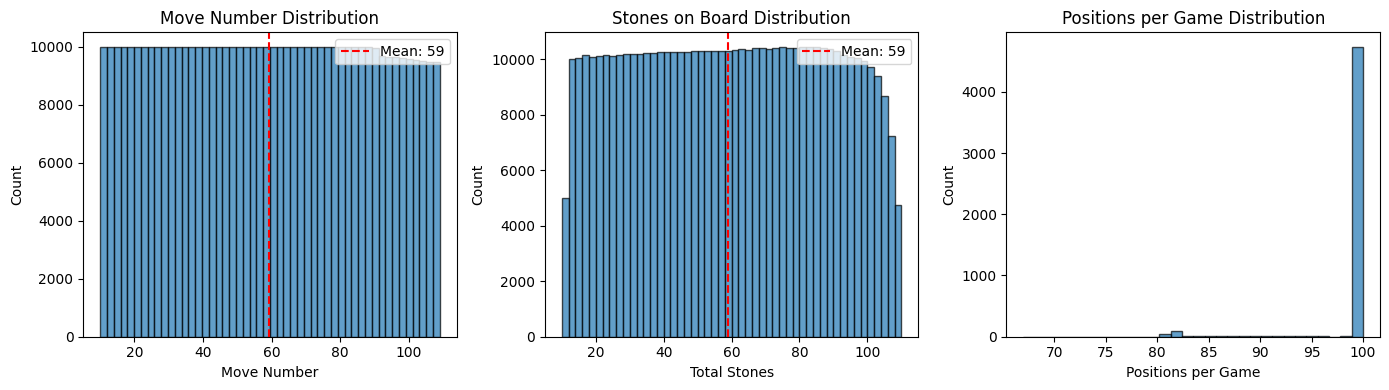

In [ ]:
# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Move number distribution
axes[0].hist(move_numbers, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Move Number')
axes[0].set_ylabel('Count')
axes[0].set_title('Move Number Distribution')
axes[0].axvline(move_numbers.mean(), color='red', linestyle='--', label=f'Mean: {move_numbers.mean():.0f}')
axes[0].legend()

# Total stones distribution
axes[1].hist(total_stones, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Total Stones')
axes[1].set_ylabel('Count')
axes[1].set_title('Stones on Board Distribution')
axes[1].axvline(total_stones.mean(), color='red', linestyle='--', label=f'Mean: {total_stones.mean():.0f}')
axes[1].legend()

# Positions per game
axes[2].hist(positions_per_game, bins=30, edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Positions per Game')
axes[2].set_ylabel('Count')
axes[2].set_title('Positions per Game Distribution')

plt.tight_layout()
plt.savefig(Path(CONFIG['output_dir']) / 'data_statistics.png', dpi=150)
plt.show()

## 4. Visualize Sample Positions

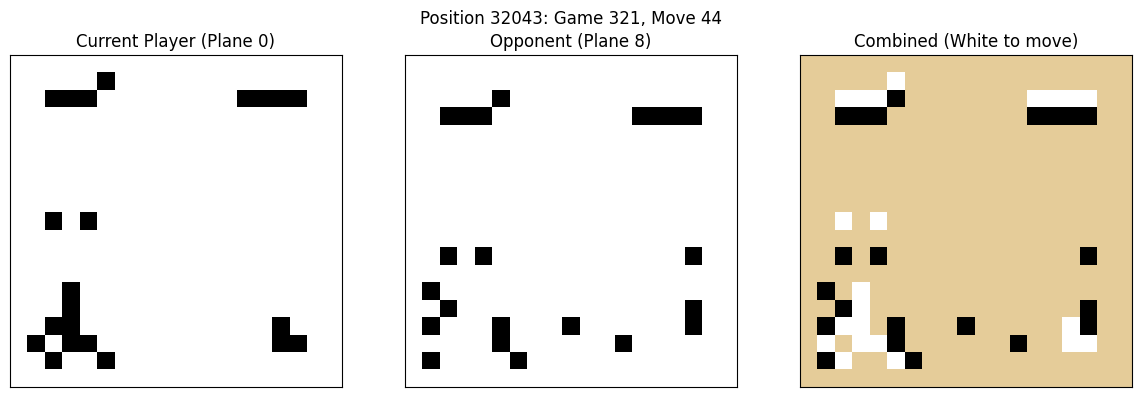

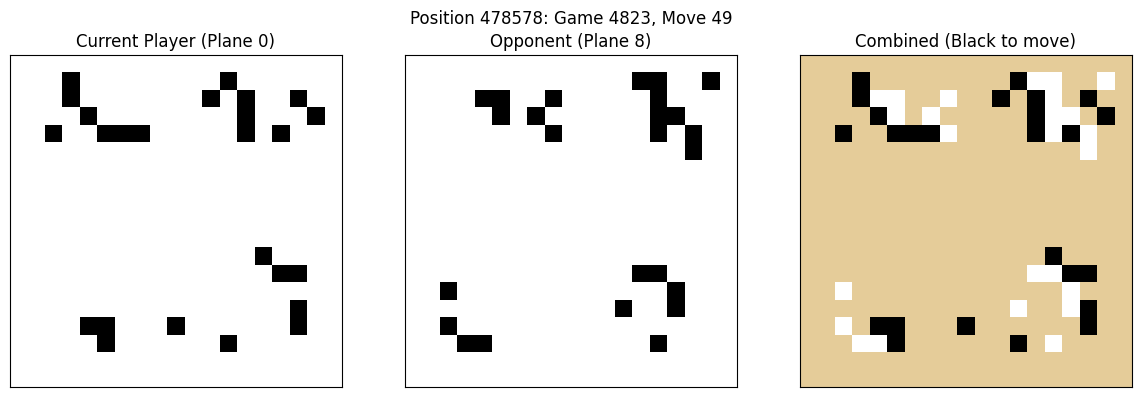

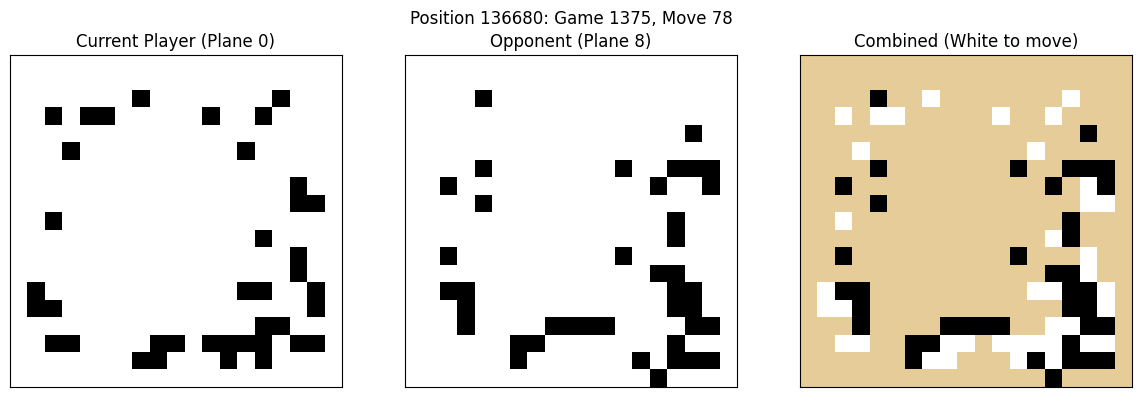

In [ ]:
def visualize_position(encoded, title="Position"):
    """Visualize an 18-plane encoded position."""
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Current player stones (plane 0)
    axes[0].imshow(encoded[0], cmap='Greys', vmin=0, vmax=1)
    axes[0].set_title('Current Player (Plane 0)')
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # Opponent stones (plane 8)
    axes[1].imshow(encoded[8], cmap='Greys', vmin=0, vmax=1)
    axes[1].set_title('Opponent (Plane 8)')
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    # Combined view
    board = np.zeros((19, 19, 3))
    board[:, :, 0] = 0.9  # Light background
    board[:, :, 1] = 0.8
    board[:, :, 2] = 0.6

    # Determine colors based on who is to move
    black_to_move = encoded[16, 0, 0] == 1
    if black_to_move:
        current_color = [0, 0, 0]  # Black
        opponent_color = [1, 1, 1]  # White
    else:
        current_color = [1, 1, 1]  # White
        opponent_color = [0, 0, 0]  # Black

    for i in range(19):
        for j in range(19):
            if encoded[0, i, j] == 1:
                board[i, j] = current_color
            elif encoded[8, i, j] == 1:
                board[i, j] = opponent_color

    axes[2].imshow(board)
    color_str = "Black" if black_to_move else "White"
    axes[2].set_title(f'Combined ({color_str} to move)')
    axes[2].set_xticks([])
    axes[2].set_yticks([])

    fig.suptitle(title)
    plt.tight_layout()
    return fig

# Show a few random positions
np.random.seed(42)
sample_indices = np.random.choice(len(positions_array), 3, replace=False)

for idx in sample_indices:
    gid = game_ids[idx]
    move = move_numbers[idx]
    fig = visualize_position(
        positions_array[idx],
        f"Position {idx}: Game {gid}, Move {move}"
    )
    plt.show()

## 5. Load Leela Zero Model

In [ ]:
from src.models.leela_zero import download_leela_weights, create_leela_zero

weights_path = Path(CONFIG['output_dir']) / 'data' / 'leela_weights.txt.gz'
weights_path.parent.mkdir(parents=True, exist_ok=True)

if not weights_path.exists():
    print("Downloading Leela Zero weights...")
    download_leela_weights(str(weights_path))
else:
    print(f"Weights exist: {weights_path}")

print("Loading Leela Zero model...")
model = create_leela_zero(weights_path=str(weights_path), device=device)
model.eval()

print(f"Model: {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Residual blocks: {len(model.residual_tower)}")

Weights exist: /content/drive/MyDrive/chaos/data/leela_weights.txt.gz
Loading Leela Zero model...
Model: 47,603,554 parameters
Residual blocks: 40


## 6. Extract Activations

In [ ]:
from src.data import ActivationExtractor
from torch.utils.data import DataLoader, TensorDataset

# Convert to tensor
positions_tensor = torch.from_numpy(positions_array).float()

# Adjust batch size for device and configure parallel loading
batch_size = CONFIG['batch_size']
if device.type == 'mps':
    batch_size = min(batch_size, 32)
    print(f"Using batch_size={batch_size} for MPS (reduced for memory)")
elif device.type == 'cuda':
    # CUDA can handle larger batches - use full CONFIG value
    print(f"Using batch_size={batch_size} for CUDA (optimized)")
else:
    # CPU fallback
    batch_size = min(batch_size, 64)
    print(f"Using batch_size={batch_size} for CPU")

# Configure data loading for optimal GPU utilization
# - num_workers: parallel data loading threads (reduces GPU wait time)
# - pin_memory: enables faster CPU->GPU transfer with page-locked memory
num_workers = 4 if device.type == 'cuda' else 0
pin_memory = device.type == 'cuda'

# Create dataloader
dataset = TensorDataset(positions_tensor)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,  # Preserve order for trajectory analysis
    num_workers=num_workers,
    pin_memory=pin_memory,
)

# Check if activations already exist
activations_dir = Path(CONFIG['output_dir']) / 'data' / 'activations'
existing_blocks = []
for block_idx in CONFIG['block_indices']:
    block_dir = activations_dir / f'block{block_idx}'
    if block_dir.exists() and list(block_dir.glob('chunk_*.npy')):
        existing_blocks.append(block_idx)

if existing_blocks:
    print(f"Activations already exist for blocks: {existing_blocks}")
    print("Delete outputs/data/activations/ to re-extract")
else:
    print("No existing activations found. Will extract.")

Using batch_size=256 for CUDA (optimized)
No existing activations found. Will extract.


In [ ]:
# Extract activations (skip if already exist)
if len(existing_blocks) < len(CONFIG['block_indices']):
    extractor = ActivationExtractor(
        model=model,
        block_indices=CONFIG['block_indices'],
        output_dir=str(activations_dir),
        device=device
    )

    print(f"Extracting activations on {device}...")
    print(f"  Blocks: {CONFIG['block_indices']}")
    print(f"  Mode: {CONFIG['spatial_mode']} ({CONFIG['pool_mode']})")
    print(f"  Positions: {len(positions_tensor):,}")

    stats = extractor.extract_and_save(
        dataloader,
        chunk_size=50000,
        spatial_mode=CONFIG['spatial_mode'],
        pool_mode=CONFIG['pool_mode']
    )

    print("\nExtraction complete:")
    for block_idx, block_stats in stats.items():
        print(f"  Block {block_idx}: {block_stats['total_samples']:,} samples")
else:
    print("Skipping extraction - activations already exist.")

Extracting activations on cuda...
  Blocks: [5, 20, 35]
  Mode: pool (mean)
  Positions: 495,995


Extracting activations: 100%|██████████| 1938/1938 [46:54<00:00,  1.45s/it, samples=451584]



Extraction complete:
  Block 5: 495,995 samples
  Block 20: 495,995 samples
  Block 35: 495,995 samples


## 7. Compute Normalization Statistics

In [ ]:
from src.data import compute_activation_stats

print("=" * 60)
print("ACTIVATION STATISTICS")
print("=" * 60)

for block_idx in CONFIG['block_indices']:
    block_dir = activations_dir / f'block{block_idx}'

    if block_dir.exists() and list(block_dir.glob('chunk_*.npy')):
        stats_path = block_dir / 'normalization_stats.npz'

        # Check if stats already computed
        if stats_path.exists():
            stats = dict(np.load(stats_path))
            print(f"\nBlock {block_idx} (loaded existing):")
        else:
            print(f"\nComputing stats for block {block_idx}...")
            stats = compute_activation_stats(str(block_dir))
            np.savez(stats_path, **stats)
            print(f"  Saved to {stats_path}")

        print(f"  Samples: {stats['count']:,}")
        print(f"  Mean: [{stats['mean'].min():.4f}, {stats['mean'].max():.4f}]")
        print(f"  Std: [{stats['std'].min():.4f}, {stats['std'].max():.4f}]")
    else:
        print(f"\nBlock {block_idx}: No activations found")

ACTIVATION STATISTICS

Computing stats for block 5...
  Saved to /content/drive/MyDrive/chaos/data/activations/block5/normalization_stats.npz
  Samples: 495,995
  Mean: [0.0495, 2.9530]
  Std: [0.0320, 0.4543]

Computing stats for block 20...
  Saved to /content/drive/MyDrive/chaos/data/activations/block20/normalization_stats.npz
  Samples: 495,995
  Mean: [0.2130, 2.9896]
  Std: [0.0476, 0.5224]

Computing stats for block 35...
  Saved to /content/drive/MyDrive/chaos/data/activations/block35/normalization_stats.npz
  Samples: 495,995
  Mean: [0.0946, 4.6200]
  Std: [0.0555, 0.5459]


## 8. Summary

In [ ]:
# ============================================================================
# Save activations as HDF5 (works for both Colab and local)
# ============================================================================
import h5py
import numpy as np
from pathlib import Path

# Determine output path
if IN_COLAB:
    activations_hdf5_path = DRIVE_ROOT / 'data' / 'activations.h5'
else:
    activations_hdf5_path = Path(CONFIG['output_dir']) / 'data' / 'activations.h5'

print(f"Saving all activations to single HDF5 file: {activations_hdf5_path}")

with h5py.File(activations_hdf5_path, 'w') as f:
    # Store metadata
    f.attrs['block_indices'] = CONFIG['block_indices']
    f.attrs['n_positions'] = len(positions_array)
    f.attrs['spatial_mode'] = CONFIG['spatial_mode']
    f.attrs['pool_mode'] = CONFIG['pool_mode']

    for block_idx in CONFIG['block_indices']:
        block_dir = Path(CONFIG['output_dir']) / 'data' / 'activations' / f'block{block_idx}'

        # Collect all chunks for this block
        chunks = sorted(block_dir.glob('chunk_*.npy'))
        if not chunks:
            print(f"  Block {block_idx}: No chunks found")
            continue

        all_activations = []
        for chunk_path in chunks:
            all_activations.append(np.load(chunk_path))

        activations = np.concatenate(all_activations, axis=0)

        # Load normalization stats
        stats_path = block_dir / 'normalization_stats.npz'
        if stats_path.exists():
            stats = dict(np.load(stats_path))
            mean = stats['mean']
            std = stats['std']
        else:
            # Compute if not present
            mean = activations.mean(axis=0)
            std = activations.std(axis=0)

        # Create dataset directly at block{idx} (flat structure)
        # This matches the expected format of ChunkedH5Dataset:
        #   - f['block5'] is a dataset (not a group)
        #   - f['block5'].attrs['mean'] and f['block5'].attrs['std'] hold normalization
        dset = f.create_dataset(
            f'block{block_idx}',
            data=activations,
            chunks=(min(10000, len(activations)), activations.shape[1]),
            compression='gzip',
            compression_opts=4
        )

        # Store normalization stats as attributes (expected by h5_dataset.py)
        dset.attrs['mean'] = mean.astype(np.float32)
        dset.attrs['std'] = std.astype(np.float32)
        dset.attrs['count'] = len(activations)

        print(f"  Block {block_idx}: {activations.shape} saved (mean/std as attrs)")

# Report file size
size_mb = activations_hdf5_path.stat().st_size / 1e6
print(f"\nTotal HDF5 file size: {size_mb:.1f} MB")
print("File ready for downstream notebooks!")
print("\nHDF5 Structure:")
print("  /block5    [N, 256] dataset with attrs['mean'], attrs['std']")
print("  /block20   [N, 256] dataset with attrs['mean'], attrs['std']")
print("  /block35   [N, 256] dataset with attrs['mean'], attrs['std']")

In [ ]:
output_dir = Path(CONFIG['output_dir'])

print("=" * 60)
print("OUTPUT FILES")
print("=" * 60)

total_size = 0
for f in sorted(output_dir.rglob('*')):
    if f.is_file() and not f.name.startswith('.'):
        size_mb = f.stat().st_size / 1e6
        total_size += size_mb
        print(f"  {f.relative_to(output_dir)}: {size_mb:.1f} MB")

print(f"\nTotal: {total_size:.1f} MB")
print("\n" + "=" * 60)
print("NEXT: Run 02_train_msae.ipynb")
print("=" * 60)

OUTPUT FILES
  data/activations/block20/chunk_0000.npy: 51.4 MB
  data/activations/block20/chunk_0001.npy: 51.4 MB
  data/activations/block20/chunk_0002.npy: 51.4 MB
  data/activations/block20/chunk_0003.npy: 51.4 MB
  data/activations/block20/chunk_0004.npy: 51.4 MB
  data/activations/block20/chunk_0005.npy: 51.4 MB
  data/activations/block20/chunk_0006.npy: 51.4 MB
  data/activations/block20/chunk_0007.npy: 51.4 MB
  data/activations/block20/chunk_0008.npy: 51.4 MB
  data/activations/block20/chunk_0009.npy: 45.5 MB
  data/activations/block20/normalization_stats.npz: 0.0 MB
  data/activations/block35/chunk_0000.npy: 51.4 MB
  data/activations/block35/chunk_0001.npy: 51.4 MB
  data/activations/block35/chunk_0002.npy: 51.4 MB
  data/activations/block35/chunk_0003.npy: 51.4 MB
  data/activations/block35/chunk_0004.npy: 51.4 MB
  data/activations/block35/chunk_0005.npy: 51.4 MB
  data/activations/block35/chunk_0006.npy: 51.4 MB
  data/activations/block35/chunk_0007.npy: 51.4 MB
  data/act